#1. Realidad causal 1: ejemplo básico

In [3]:
import random
import numpy as np
from numpy.random import normal as noise
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as normal
from scipy.stats import norm
from scipy.stats import uniform

In [4]:
import linear_model as lm
from linear_model import BayesianLinearModel

In [5]:
random.seed(123)
np.random.seed(123)


In [6]:
N = 5000

def simular1(N=5000,do_x=None):
  # Si hay intervencion, usar x = do_x, sino generarlo del modelo original
  Z = np.random.uniform(-3,3, size=N)
  if do_x is None:
    X = 1 + 3*Z + 2*Z**3 + np.random.normal(size=N,scale=6)
  else:
    X = np.full(N, do_x)
  Y = -1 - 2*X + 6*Z**2 + np.random.normal(size=N,scale=1)
  return Z, X, Y
# Generamos los datos sin intervenciones
N = 5000
Z1s, X1s, Y1s = simular1(N)

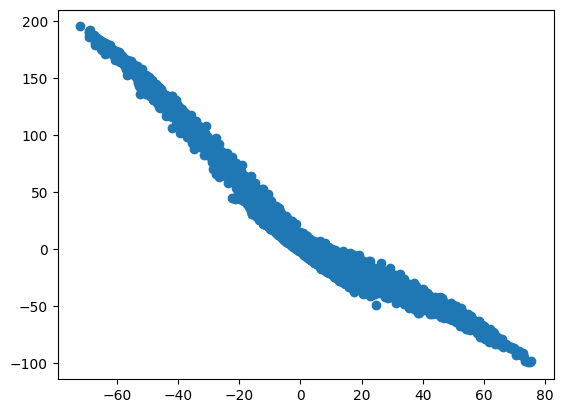

In [7]:
# Creamos el modelo
PHI1 = np.concatenate([
  np.ones(N).reshape(N, 1), # c_0
  X1s.reshape(N, 1), # c_x X
  (Z1s**2).reshape(N, 1)], # c_z Z^2
  axis=1)

# Ajustamos el modelo
blm1= BayesianLinearModel(basis=lambda x: x)
blm1.update(PHI1, Y1s.reshape(N,1) )

# Obtenemos las estimaciones
mean1 = blm1.location
cov1 = blm1.dispersion
ev1 = blm1.evidence()

plt.scatter(X1s,Y1s)
plt.show()

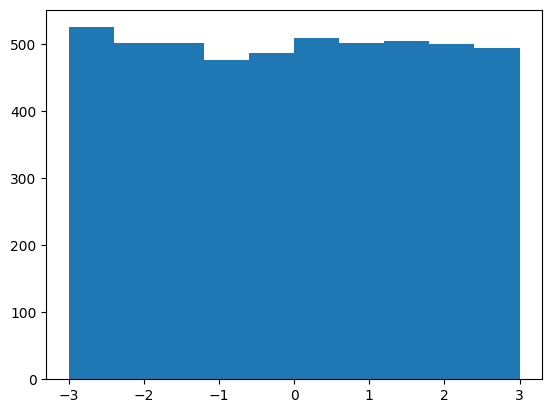

In [8]:
# Efecto causal de x en y para un z especifico
# P(y|do(x),z) = P(y|x,z)
#              = sum_w P(y|x,z,w) P(w)
x = 0; z = 0; y = 1
_,_,py_xz = blm1.predict(X=np.array([1,x,z**2]).reshape((1,3)),
                          y=np.array([y]))

plt.hist(Z1s)
plt.show()

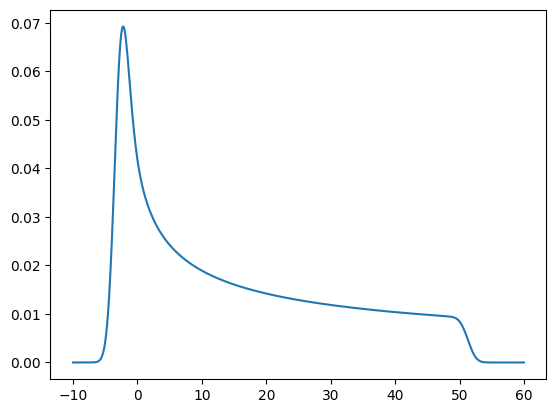

In [9]:
# P(y|do(x)) = int_z P(y|x,z) P(z) dz (una integral)
def p1_Y_doX(y,x,blm=blm1, dz=0.01):
  res = 0
  for z in np.arange(-3,3+dz,dz):
    _,_,py_xz = blm.predict(X=np.array([1,x,z**2]).reshape((1,3)),
                          y=np.array([y]))
    pz = uniform.pdf(z,-3,6)
    res += py_xz*pz*dz

  return res

y_grilla = np.arange(-10,60,0.05)
plt.plot(y_grilla, p1_Y_doX(y_grilla,x=1))
plt.show()

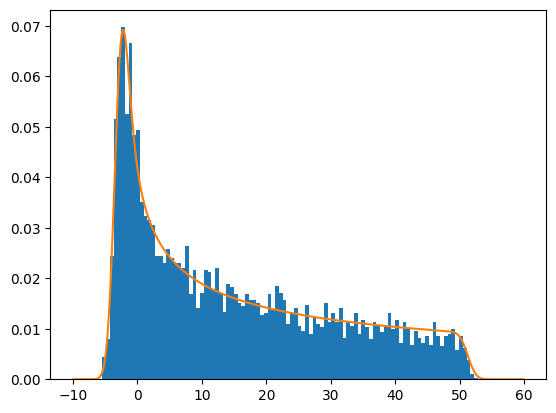

In [10]:
plt.hist(simular1(N=5000, do_x=1)[2], bins=100, density=True)
plt.plot(y_grilla, p1_Y_doX(y_grilla,x=1))
plt.show()

Hacemos un modelo alternativo

In [11]:
# P(y|x,z,w) = N(y| w0 + w1 x + w2 z, beta**-1)
PHI1_alternativa = np.concatenate([
  np.ones(N).reshape(N, 1), # c_0
  X1s.reshape(N, 1), # c_x X
  Z1s.reshape(N, 1)], # c_z Z
  axis=1)

# Ajustamos el modelo
blm1a= BayesianLinearModel(basis=lambda x: x)
blm1a.update(PHI1_alternativa, Y1s.reshape(N,1) )

# Obtenemos las estimaciones
print(blm1a.location)
print(blm1a.dispersion)
print(blm1a.evidence())

x = 0; z = 0; y = 1
_,_,py_xz = blm1a.predict(X=np.array([1,x,z]).reshape((1,3)),
                          y=np.array([y]))


[[17.28164484]
 [-2.05429077]
 [ 0.48441376]]
[[ 2.01545174e-04 -1.71537404e-06  2.48136092e-05]
 [-1.71537404e-06  1.92332725e-06 -2.66968819e-05]
 [ 2.48136092e-05 -2.66968819e-05  4.36484361e-04]]
-21045.132740986846


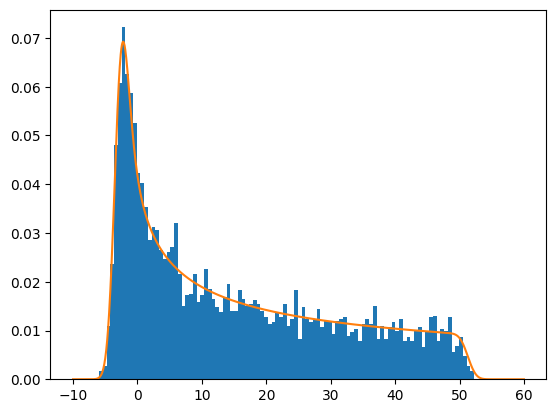

In [12]:
dy = 0.05
y_grilla = np.arange(-10,60,dy)
plt.hist(simular1(N=5000, do_x=1)[2], bins=100, density=True)
plt.plot(y_grilla, p1_Y_doX(y_grilla,x=1))
plt.show()

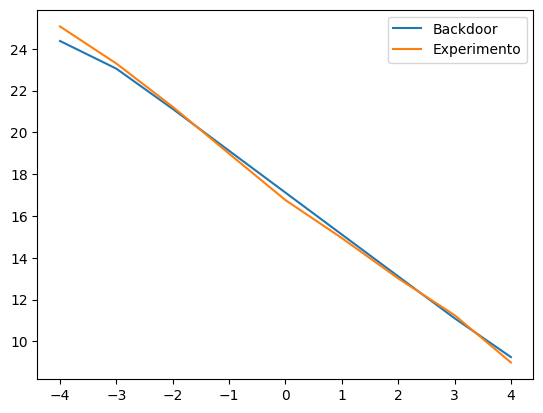

In [13]:
#E[y|do(x)] = sum_y y P(y|do(x))
def media(y_grilla, py_dox):
  dy = y_grilla[1]-y_grilla[0]
  return np.sum(y_grilla * py_dox)*dy


x_grilla = np.arange(-4,4+1,1)
medias1_estimadas_con_backdoor = []
medias1_estimadas_con_experimento = []

for x in x_grilla:
  medias1_estimadas_con_backdoor.append(media(y_grilla, p1_Y_doX(y_grilla,x=x)[:,0]))
  _,_,Yx = simular1(N=5000, do_x=x)
  medias1_estimadas_con_experimento.append(np.mean(Yx))

plt.plot(x_grilla, medias1_estimadas_con_backdoor, label="Backdoor")
plt.plot(x_grilla, medias1_estimadas_con_experimento, label="Experimento")
plt.legend()
plt.show()


#np.sum(y_grilla * p1_Y_doX(y_grilla,x=1)[:,0])*dy

#4. Realidad causal 4

In [14]:
def simular4(N, do_x=None):
  # Si hay intervencion, usar x = do_x, sino generarlo del modelo original
  Z = np.random.normal(size=N, scale=1)
  if do_x is None:
    X = Z**2 + np.random.normal(size=N, scale=1)
  else:
    X = np.full(N, do_x)
  M = 2*Z**2 + 10*X + np.random.normal(size=N, scale=1)
  Y = -1 + 2*M**2 + np.random.normal(size=N, scale=1)
  return Z, X, M, Y

N = 10000
Z4s, X4s, M42, Y4s = simular4(N)

In [15]:
 #Base de la regresion
PHI4 = np.concatenate([
  np.ones(N).reshape(N, 1),
  (X4s**2).reshape(N, 1),
  (X4s*Z4s**2).reshape(N, 1),
  (Z4s**4).reshape(N, 1)],
  axis=1)

# Modelo lineal
blm4= BayesianLinearModel(basis=lambda x: x)
blm4.update(PHI4, Y4s.reshape(N,1) )
print("Evidencia = ", blm4.evidence())

# Estimaciones de los pesos w
m4 = blm4.location
S4 = blm4.dispersion

Evidencia =  -59101.173788394495


In [16]:
m4

array([[  0.61667959],
       [199.88346553],
       [ 78.91600008],
       [  9.45333543]])

In [17]:
blm4.dispersion[3,3]

8.143005161853818e-05

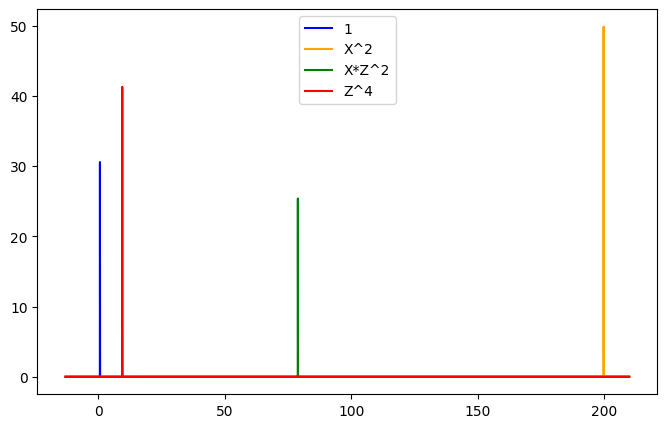

In [18]:
w_grilla = np.arange(-13, 210, 0.01)

plt.figure(figsize=(8, 5))
nombres = ["1", "X^2", "X*Z^2", "Z^4"]
colores = ['blue', 'orange', 'green', 'red']  #

for i in range(4):
    pdf = norm(blm4.location[i], np.sqrt(blm4.dispersion[i, i])).pdf(w_grilla)
    plt.plot(w_grilla, pdf, label=nombres[i], color=colores[i])

plt.legend()
plt.show()

In [19]:
def p4_Y_doX(y,x,blm4, z_grilla = np.arange(-4,4,0.01)):
  res = 0
  dz = z_grilla[1]-z_grilla[0]
  for z in z_grilla:
    pz = normal(0,1).pdf(z)
    mu_y_xz, S_y_xz, py_xz = blm4.predict(
      X=np.array([1,x**2,x*z**2,z**4]).reshape((1,4)),
      y=np.array([y]), variance=True)
    res += (pz*py_xz)*dz
  return res

In [20]:
def Y_doX(x, N=10000):
  # Generar una muestra P(y|do(x))
  Z, X, M, Y = simular4(N, do_x=x)
  return Y

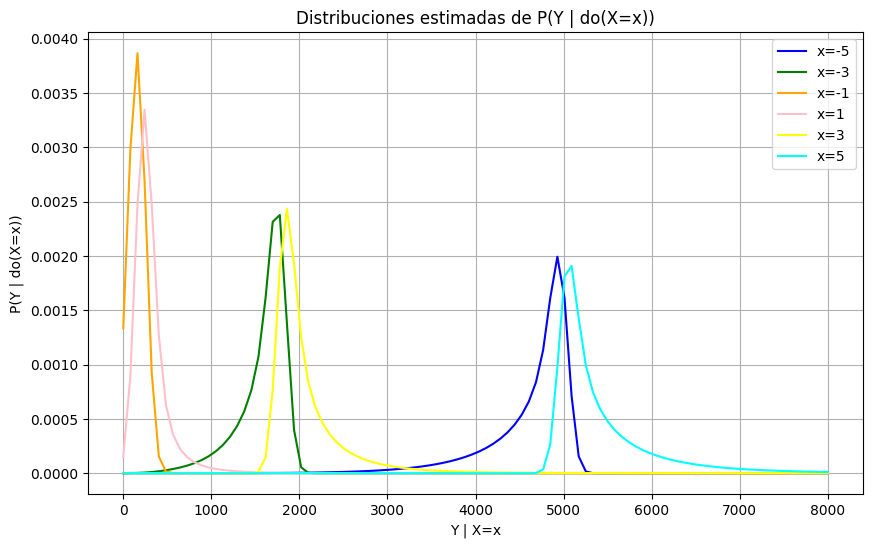

In [22]:
valores_x = [-5, -3, -1, 1, 3, 5]
colores = ['blue', 'green', 'orange', 'pink', 'yellow', 'cyan']

y_grilla = np.linspace(0, 8000, 100)

plt.figure(figsize=(10, 6))

for i, x in enumerate(valores_x):
    densidad_y = [p4_Y_doX(y, x, blm4) for y in y_grilla]
    plt.plot(y_grilla, densidad_y, label=f"x={x}", color=colores[i])

plt.xlabel("Y | X=x")
plt.ylabel("P(Y | do(X=x))")
plt.title("Distribuciones estimadas de P(Y | do(X=x))")
plt.legend()
plt.grid()
plt.show()